In [ ]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
RANDOM_SEED = 42
BATCH_SIZE = 16
NUM_EPOCHS = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
normalize = transforms.Normalize(
    mean=[0.4914, 0.4822, 0.4465],
    std=[0.2023, 0.1994, 0.2010],
)

    # define transforms
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    normalize,
])

In [ ]:
dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train = True, 
    download=True, 
    transform=transform)

test = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
torch.manual_seed(RANDOM_SEED)
train_size = len(dataset)

STEPS_PER_EPOCH = len(dataset) // BATCH_SIZE
STEPS_PER_TEST_EPOCH = len(test) // BATCH_SIZE

classes = dataset.classes
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=2, shuffle=True, pin_memory=True)
test_loader = DataLoader(test, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)

images.shape: torch.Size([16, 3, 256, 256])


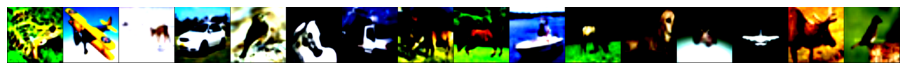

In [ ]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(torchvision.utils.make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [ ]:
class AlexNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=256*6*6, out_features=4096),
            nn.ReLU(),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Linear(in_features=4096, out_features=1000),
        )
        
    def forward(self, x):
        x = self.net(x)
        x = self.avgpool(x)
        x = x.flatten(start_dim=1)
        x = self.classifier(x)
        
        return x

In [ ]:
model = AlexNet().to(device)

In [ ]:
optimizer = torch.optim.SGD(params=model.parameters(), lr = 0.001, momentum=0.9, nesterov=True)
loss_fn = torch.nn.CrossEntropyLoss()
lmbda = lambda epoch: 0.9
scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)

In [ ]:
def testing(data_loader):
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(data_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return test_loss / total, correct/total*100

In [ ]:
avg_test_loss_history = []
avg_test_accuracy_history = []
avg_train_loss_history = []
avg_train_accuracy_history = []

loss_history = []
accuracy_history = []

In [ ]:
for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch}:")
    for batch_idx, (image, label) in enumerate(train_loader):

        model.train()
        images, labels = image.to(device), label.to(device)
        optimizer.zero_grad()
        
        y_pred = model(images)
        loss = loss_fn(y_pred, labels)
        loss.backward()
        optimizer.step()

        loss_history.append(loss.item() / BATCH_SIZE)

        total = 0
        correct = 0
        _, predicted = y_pred.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accuracy_history.append(correct / total * 100)

        if (batch_idx+1)%250==0:
            print(f'Batch : {batch_idx+1} | Train_Loss : {sum(loss_history[-250:]) / 250} | Train_Accuracy : {sum(accuracy_history[-250:]) / 250} |', end='\n')
        
    avg_train_loss_history.append(sum(loss_history[-STEPS_PER_EPOCH:]) / STEPS_PER_EPOCH)
    avg_train_accuracy_history.append(sum(accuracy_history[-STEPS_PER_EPOCH:]) / STEPS_PER_EPOCH)

    scheduler.step()
    print(f'Mean loss for this epoch was {avg_train_loss_history[-1]}')
    print(f'Mean accuracy for this epoch was {avg_train_accuracy_history[-1]}')
    print()

    model.eval()
    with torch.inference_mode():
        test_loss, test_acc = testing(test_loader)
        avg_test_loss_history.append(test_loss)
        avg_test_accuracy_history.append(test_acc)
    print(f'Test Loss : {test_loss} | Test Accuracy : {test_acc}')
    print()

Epoch 0:
Batch : 250 | Train_Loss : 0.2530007961988449 | Train_Accuracy : 9.575 |
Batch : 500 | Train_Loss : 0.1389629358649254 | Train_Accuracy : 18.125 |
Batch : 750 | Train_Loss : 0.1259137795865536 | Train_Accuracy : 27.725 |
Batch : 1000 | Train_Loss : 0.11888209441304207 | Train_Accuracy : 31.4 |
Batch : 1250 | Train_Loss : 0.11185185119509697 | Train_Accuracy : 34.275 |
Batch : 1500 | Train_Loss : 0.1083487751185894 | Train_Accuracy : 36.825 |
Batch : 1750 | Train_Loss : 0.103808159917593 | Train_Accuracy : 39.425 |
Batch : 2000 | Train_Loss : 0.10119602265954018 | Train_Accuracy : 40.6 |
Batch : 2250 | Train_Loss : 0.09845628401637077 | Train_Accuracy : 42.825 |
Batch : 2500 | Train_Loss : 0.09635413800179958 | Train_Accuracy : 44.4 |
Batch : 2750 | Train_Loss : 0.09421442812681198 | Train_Accuracy : 43.9 |
Batch : 3000 | Train_Loss : 0.09387285563349723 | Train_Accuracy : 45.45 |
Mean loss for this epoch was 0.11918498620152473
Mean accuracy for this epoch was 35.082

Test Los

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

test_loss = 0
correct = 0
total = 0
true_labels = []
predictions = []

for batch_idx, (input, target) in enumerate(test_loader):
    inputs, targets = input.to(device), target.to(device)
    outputs = model(inputs)
    loss = loss_fn(outputs, targets)

    test_loss += loss.item()
    _, predicted = outputs.max(1)
    total += targets.size(0)
    correct += predicted.eq(targets).sum().item()

    true_labels.extend(list(target.numpy()))
    predictions.extend(list(predicted.to("cpu").numpy()))

print(f"Final Test Loss {test_loss / total}")
print(f"Final Test Accuracy {correct/total * 100}")

Final Test Loss 0.06082305776802823
Final Test Accuracy 79.89


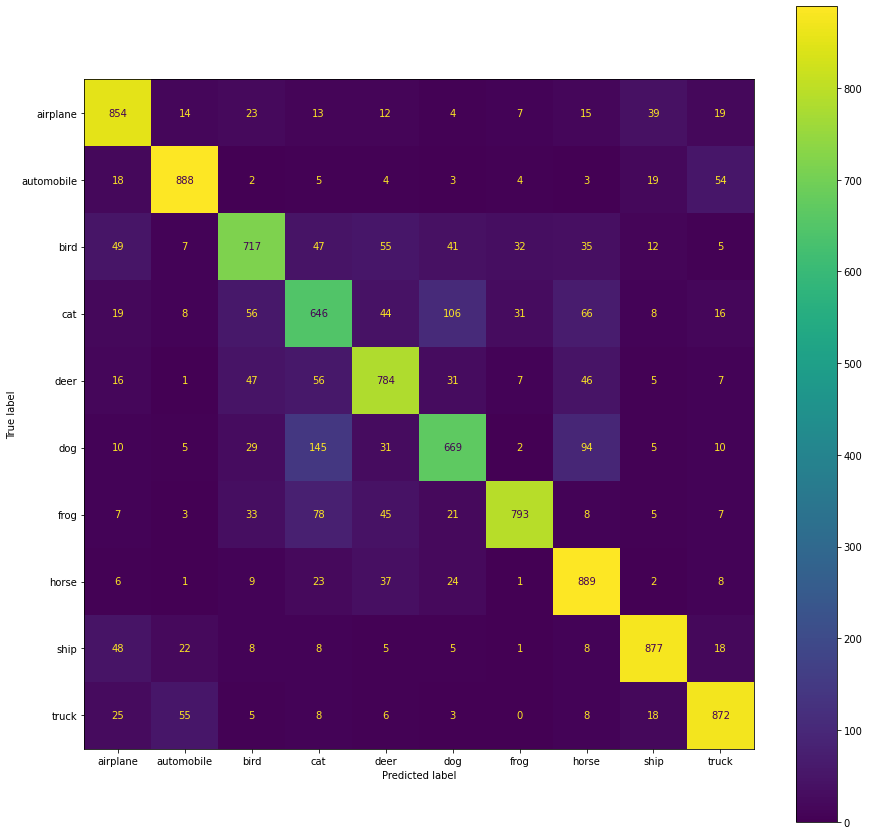

In [ ]:
cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(15, 15))
disp.plot(ax=ax)
plt.show()

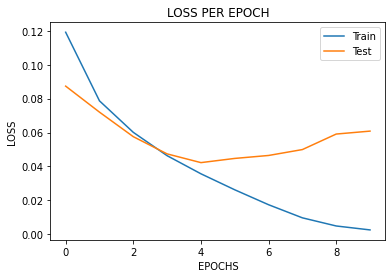

In [ ]:
plt.plot(avg_train_loss_history,label = "Train")
plt.plot(avg_test_loss_history , label = "Test")
plt.title('LOSS PER EPOCH')
plt.xlabel("EPOCHS")
plt.ylabel("LOSS")
plt.legend()
plt.show()

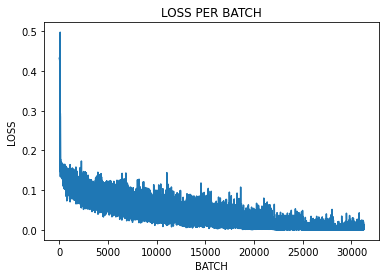

In [ ]:
plt.plot(loss_history)
plt.title('LOSS PER BATCH')
plt.xlabel("BATCH")
plt.ylabel("LOSS")
plt.show()

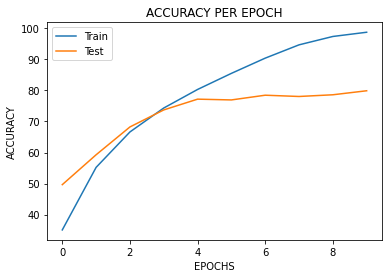

In [ ]:
plt.plot(avg_train_accuracy_history , label = "Train")
plt.plot(avg_test_accuracy_history , label = "Test")
plt.title('ACCURACY PER EPOCH')
plt.xlabel("EPOCHS")
plt.ylabel("ACCURACY")
plt.legend()
plt.show()